In [61]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        #data['s2n'] = res['s2n']
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data

In [62]:
def make_data(rng, FbyB, shear, version=0, first=False, SbyN=20):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    FbyB: float
        source by background ratio
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear,
        g2=0,
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    
    backgrounds = []
    ngrid = im.array.shape[0]
    flux_tmp = np.sum((im.array)[ngrid//2-2:ngrid//2+3, ngrid//2-2:ngrid//2+3])
    std_tmp =  5
    F = SbyN**2.*(1+FbyB)/FbyB
    B = F/FbyB
    B_val = B/25.0
    F_val=F/25.0
        
    im = (im/flux_tmp)*F
    
    
    if version==0:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val + im.array)/std_tmp
        variance_array = np.ones_like(im.array)*(B_val+im.array)/std_tmp**2
        im += noise_image
        
        if first:
            backgrounds.append(noise_image)
            
    if version==1:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val+F_val)/std_tmp
        variance_array = np.ones_like(im.array)*(B_val+F_val)/std_tmp**2
        im += noise_image
        
        if first:
            backgrounds.append(noise_image)
            
    
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    if version==0:
        wt = 1.0/np.average(variance_array)*np.ones_like(variance_array)
    if version==1:
        wt = 1.0/variance_array
        
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs, backgrounds

In [63]:
def analyze(rng, num_tests, num_gals, FBratioArr, shear_true, version=0, first=False, SbyN=20):
    data = []
    x = []
    y = []
    shear_error = []
    s2n_error = []
    backgrounds = []
    
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        
        #makes first true for every new noise value
        if first is False:
            first = True
        
        for j in range(num_gals):
            imgdata = make_data(rng=rng, FbyB=FBratioArr[i], shear=shear_true[i], version=version, first=first, SbyN=20)
            obs = imgdata[0]
            
            if(len(imgdata[1]) > 0):
                backgrounds.append(imgdata[1][0])
                
                            
            if first is True:
                first = False
                
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                
        data.append(np.hstack(dlist))
        #data contains average of all galaxy data
        
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        
        #s2n = data[i]['s2n'][w].mean()
        #s2n_err = data[i]['s2n'][w].std(axis=0)/np.sqrt(w.size)
        #s2n_error.append(s2n_err)
        
        
        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11
        
        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)
        
        #x.append(s2n)
        x.append(FBratioArr[i])
        y.append(shear[0])
            
    return (x, y, s2n_error, shear_error, backgrounds)

In [64]:
rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

'\ngmeas/gtrue - 1 = m\n'

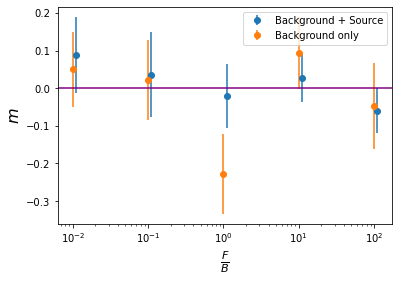

In [65]:
plt.errorbar(np.array(ans1[0])*1.1, (np.array(ans1[1])/shear_true[0]-1), yerr=np.array(ans1[3])/shear_true[0], fmt='o', label='Background + Source')
plt.errorbar(ans2[0], (np.array(ans2[1])/shear_true[0]-1), yerr=np.array(ans2[3])/shear_true[0], fmt='o', label='Background only')
plt.axhline(0, color="purple")
plt.xscale("log")
plt.xlabel(r'$\frac{F}{B}$', fontsize=16)
plt.ylabel(r'$m$', fontsize=16)
plt.legend()
"""
gmeas/gtrue - 1 = m
"""

In [124]:
import numpy as np
import scipy.optimize
def biasFunc(x, m, c):
    '''Systematic bias of shear estimation
    Parameters:
    ----
    x:  input shear
    m:  multiplicative bias
    c:  additive bias

    Returns:
    ----
    y:  estimated shear
    '''
    y   =   (1+m) * x + c
    return y

# see here
# (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
# for documentation of scipy.optimize.curve_fit

FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_tests = len(FBratioArr)
num_gals = 2000
g_true= [-0.03, -0.01, 0, 0.01, 0.03]
#g1_true = np.linspace(-0.03,0.03,len(FBratioArr))

analysis_BandS= analyze(rng, num_tests, num_gals, FBratioArr, g_true, version=0, first = True, SbyN=20)
analysis_Bonly = analyze(rng, num_tests, num_gals, FBratioArr, g_true, version=1, first = True, SbyN=20)

len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4


Do the shapes match for V1? True
Do the shapes match for V2? True
g1_est = [-0.03072500443915958, -0.009838495944679124, 0.00020701863615943164, 0.010007519674143055, 0.030496358367252806]
g2_est = [-0.030709258911789907, -0.010714592262933155, 0.0012285166767571794, 0.010361395996887096, 0.030177360790342417]
g1_true = [-0.03, -0.01, 0, 0.01, 0.03]
g1_sigma = [0.0006955893312349061, 0.000687024062059201, 0.0005629474804268103, 0.0004296982016500624, 0.00039962955870509215]
g2_sigma = [0.0006913053744054074, 0.0006939755964146318, 0.0006973514444935694, 0.0007147432757633055, 0.0007076574523300082]

m1 = 0.016335190416090117
c1 = 2.70290825773975e-06

m2 = 0.018937697448802967
c2 = 6.845010557003853e-05


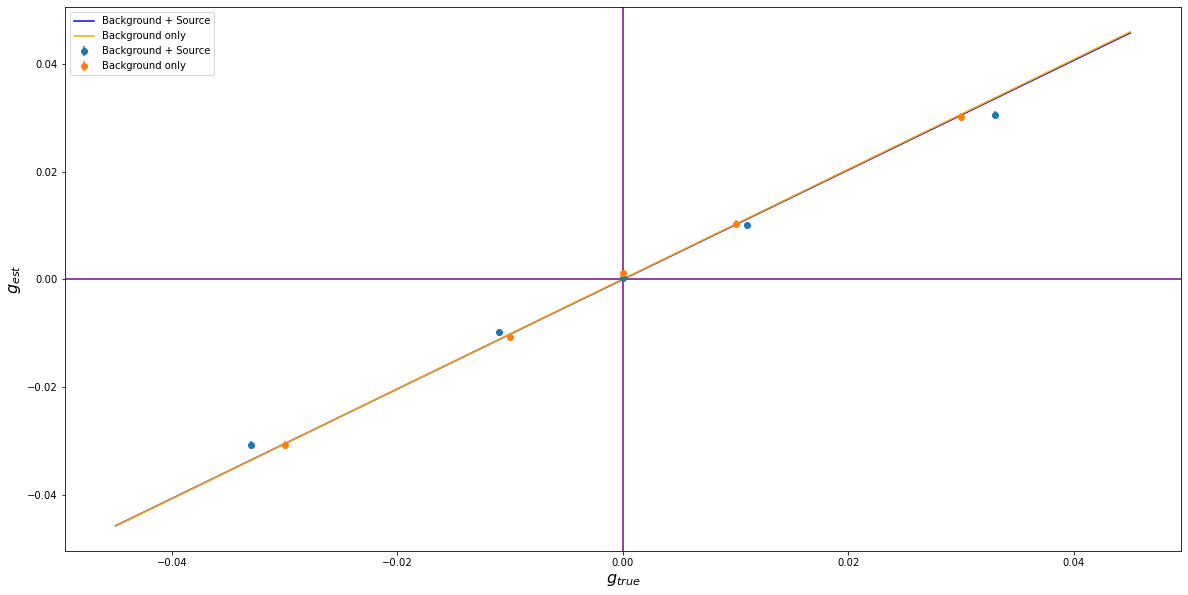

In [125]:
x = np.linspace(-.03*1.5, .03*1.5, len(FBratioArr))
y = x

FbyBlist = analysis_BandS[0]
g1_est = analysis_BandS[1]
g1_sigma = analysis_BandS[3]

g2_est = analysis_Bonly[1]
g2_sigma = analysis_Bonly[3]

print("Do the shapes match for V1?", np.shape(g1_est) == np.shape(g1_sigma) == np.shape(g_true))
print("Do the shapes match for V2?", np.shape(g2_est) == np.shape(g2_sigma) == np.shape(g_true))

print("g1_est =", g1_est)
print("g2_est =", g2_est)
print("g1_true =", g_true)
print("g1_sigma =", g1_sigma)
print("g2_sigma =", g2_sigma)

popt1, pcov1 = scipy.optimize.curve_fit(biasFunc, g_true, g1_est, sigma = g1_sigma)
print("\nm1 =", popt1[0])
print("c1 =", popt1[1])
popt2, pcov2 = scipy.optimize.curve_fit(biasFunc, g_true, g2_est, sigma = g2_sigma)
print("\nm2 =", popt2[0])
print("c2 =", popt2[1])

plt.figure(figsize=(20, 10))
plt.errorbar(np.array(g_true)*1.1, g1_est, yerr=g2_sigma, fmt='o', label='Background + Source')
plt.errorbar(g_true, g2_est, yerr=g2_sigma, fmt='o', label='Background only')
#plt.plot(x, y, color="purple")
plt.plot(np.array(x), biasFunc(np.array(x), popt1[0], popt1[1]), label = 'Background + Source', color = "blue")
plt.plot(np.array(x), biasFunc(np.array(x), popt2[0], popt2[1]), label = 'Background only', color = "orange")
plt.axhline(0, color="purple")
plt.axvline(0, color="purple")
plt.xlabel(r'$g_{true}$', fontsize=16)
plt.ylabel(r'$g_{est}$', fontsize=16)
plt.legend()